## Siapkan Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [ ]:
df = pd.read_csv("Sales Transaction v.4a.csv")
df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


## Pembersihan Data

**Data Hilang**

In [ ]:
df.isnull().sum()

,0
TransactionNo,0
Date,0
ProductNo,0
ProductName,0
Price,0
Quantity,0
CustomerNo,55
Country,0


In [ ]:
df = df.dropna()
df.isnull().sum()

,0
TransactionNo,0
Date,0
ProductNo,0
ProductName,0
Price,0
Quantity,0
CustomerNo,0
Country,0


**Data Duplikat**

In [ ]:
df = df.drop_duplicates()

**Jumlah Data**

(setelah menghapus data hilang dan data duplikat)

In [ ]:
len(df)

531095

**Konversi Data Tanggal dalam Tipe Datatime**

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531095 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TransactionNo  531095 non-null  object        
 1   Date           531095 non-null  datetime64[ns]
 2   ProductNo      531095 non-null  object        
 3   ProductName    531095 non-null  object        
 4   Price          531095 non-null  float64       
 5   Quantity       531095 non-null  int64         
 6   CustomerNo     531095 non-null  float64       
 7   Country        531095 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.5+ MB


**Identifikasi Outlier**

Indentifikasi ini dilakukan dengan boxplot terhadap nilai pada 'Price', 'Quantity', dan 'Revenue'. Outliers ini akan dianalisis sebelum ditentukan apakah outliers perlu dihapus atau tidak perlu dihapus.

/tmp/ipython-input-2410919879.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[col] for col in numeric_cols], labels=numeric_cols)


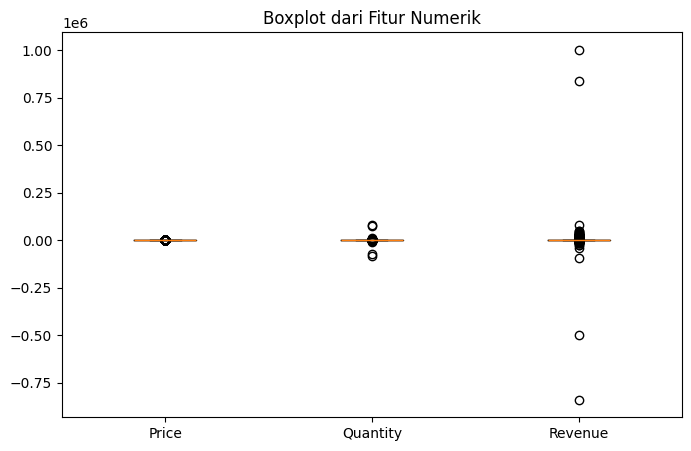

In [ ]:
numeric_cols = ['Price', 'Quantity', 'Revenue']

df['Revenue'] = df['Price'] * df['Quantity']

plt.figure(figsize=(8,5))
plt.boxplot([df[col] for col in numeric_cols], labels=numeric_cols)
plt.title('Boxplot dari Fitur Numerik')
plt.show()

## Analisis

In [ ]:
conn = sqlite3.connect('ecommerce.db')

df.to_sql('sales', conn, if_exists='replace', index=False)

531095

Jumlah data yang tersimpan pada tabel 'sales' di database 'ecommerce.db' berjumlah **531.095**.

### KPI

**Berapa Total Penjualan Keseluruhan?**

In [ ]:
query = """
SELECT SUM(Revenue) AS total_revenue
FROM sales
WHERE Quantity > 0 AND Price > 0;
"""
pd.read_sql_query(query, conn)

,total_revenue
0,6.278130e+07


Total Pendapatan kotor berjumlah **£62.781.300**

**Berapa Total Transaksi?**

In [ ]:
query = """
SELECT
  COUNT(DISTINCT TransactionNo) AS total_transaction
FROM sales
WHERE Quantity > 0 AND Price > 0;
"""
pd.read_sql_query(query, conn)

,total_transaction
0,19789


Total transaksi berjumlah **19.789** dari seluruh dunia.

**Berapa Total Pelanggan?**

In [ ]:
query = """
SELECT
  COUNT(DISTINCT CustomerNo) AS total_customers
FROM sales
WHERE Quantity > 0 AND Price > 0;
"""
pd.read_sql_query(query, conn)

,total_customers
0,4718


Total pelanggan berjumlah **4.718**.

**Revenue Rata-rata per Transaksi?**

In [ ]:
query = """
SELECT
  SUM(Revenue) * 1.0 / COUNT(DISTINCT TransactionNo) AS avg_order_value
FROM sales
WHERE Quantity > 0 AND Price > 0;
"""
pd.read_sql_query(query, conn)

,avg_order_value
0,3172.535476


Rata-rata seluruh pendapatan per transaksi bernilai **£3.172,53**.

In [ ]:
# tanpa outlier

Q1 = df['Revenue'].quantile(0.25)
Q3 = df['Revenue'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

query = f"""
SELECT
  SUM(Revenue) * 1.0 / COUNT(DISTINCT TransactionNo) AS avg_order_value
FROM sales
WHERE Revenue < {upper_bound} AND Quantity > 0 AND Price > 0;
"""
pd.read_sql_query(query, conn)

,avg_order_value
0,1699.132428


Rata-rata pendapatan (tanpa outlier) per transaksi bernilai **£1.699,13**.

**Revenue per Pelanggan?**

In [ ]:
query = """
SELECT
  CustomerNo,
  SUM(Revenue) AS total_spent
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY CustomerNo
ORDER BY total_spent DESC
LIMIT 10;
"""
pd.read_sql_query(query, conn)

,CustomerNo,total_spent
0,14646.0,2112282.03
1,16446.0,1002741.57
2,14911.0,914204.19
3,12415.0,900545.54
4,18102.0,897137.36
5,17450.0,891069.53
6,12346.0,840113.80
7,14156.0,694202.51
8,13694.0,646116.78
9,17511.0,639006.19


In [ ]:
query = """
SELECT
  CustomerNo,
  SUM(Revenue) AS total_spent
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY CustomerNo
ORDER BY total_spent ASC
LIMIT 10;
"""
pd.read_sql_query(query, conn)

,CustomerNo,total_spent
0,16937.0,5.97
1,13775.0,11.53
2,12810.0,11.98
3,14435.0,12.38
4,12309.0,12.86
5,12081.0,13.27
6,16724.0,13.27
7,14025.0,14.09
8,17683.0,14.48
9,17699.0,14.48


Total pendapatan yang diterima dari setiap pelanggan beragam dari **£5.97** (paling sedikit) hingga **£2.112.282,03** (terbanyak)

### Tren Waktu

**Bagaimana Tren Penjualan per Bulan?**

In [ ]:
query = """
SELECT
  strftime('%Y-%m', Date) AS month,
  SUM(Revenue) AS monthly_revenue
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY month
ORDER BY month;
"""
monthly = pd.read_sql_query(query, conn)
monthly

,month,monthly_revenue
0,2018-12,4.397648e+06
1,2019-01,4.548423e+06
2,2019-02,3.327343e+06
3,2019-03,4.384670e+06
4,2019-04,3.579310e+06
5,2019-05,4.569952e+06
6,2019-06,4.486050e+06
7,2019-07,4.571495e+06
8,2019-08,4.749801e+06
9,2019-09,6.613773e+06


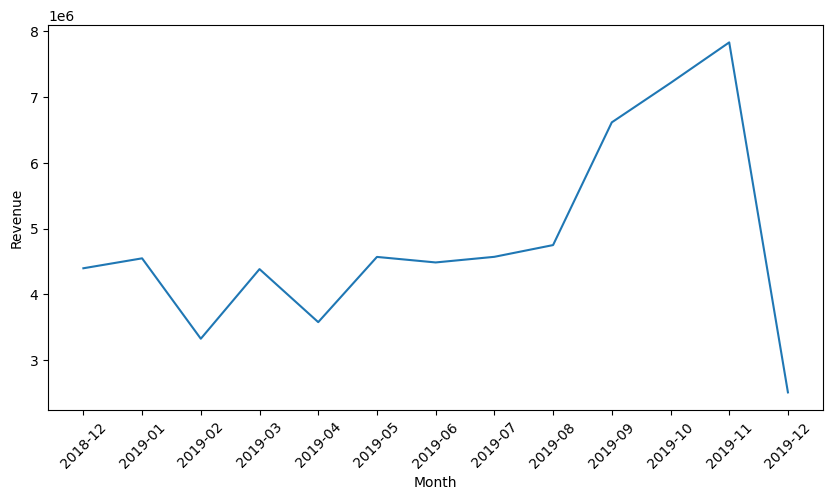

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(monthly['month'], monthly['monthly_revenue'])
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

Grafik pendapatan menunjukkan tren kenaikan dari bulan **Agustus sampai Oktober**, dengan puncak yang terlihat pada **November**, yang mengindikasikan kemungkinan permintaan musiman atau acara promosi.

**Bagaimana Tren Penjualan per Minggu?**

In [ ]:
query = """
SELECT
  strftime('%Y-%W', Date) AS year_week,
  SUM(Revenue) AS weekly_revenue
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY year_week
ORDER BY year_week;
"""
weekly = pd.read_sql_query(query, conn)
weekly

,year_week,weekly_revenue
0,2018-48,692086.45
1,2018-49,1531721.91
2,2018-50,1431665.15
3,2018-51,742174.88
4,2019-00,594112.81
5,2019-01,1048802.58
6,2019-02,1751156.01
7,2019-03,839050.82
8,2019-04,793250.81
9,2019-05,635289.59


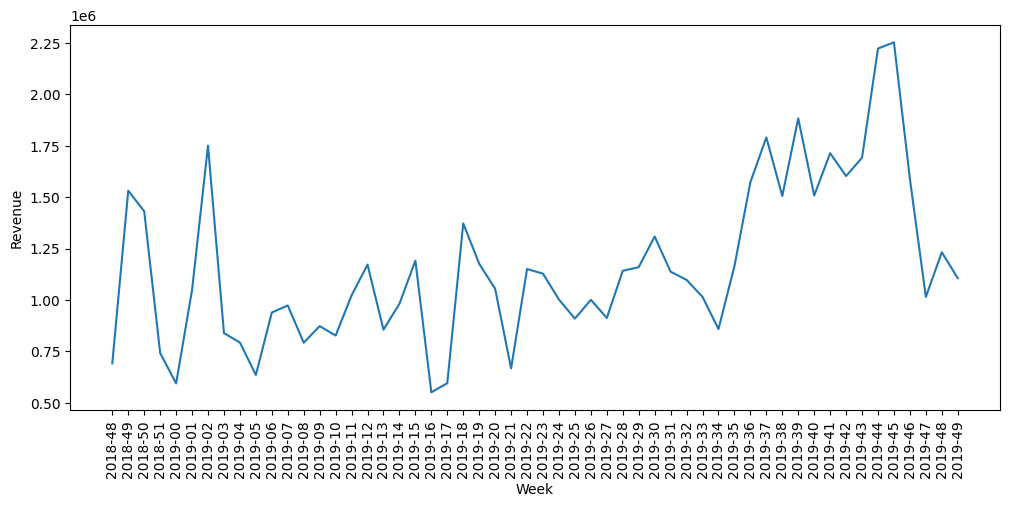

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(weekly['year_week'], weekly['weekly_revenue'])
plt.xticks(rotation=90)
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.show()

Grafik pendapatan menunjukkan tren kenaikan yang signifikan pada beberapa minggu di **akhir tahun 2018, awal tahun 2019, minggu 17 tahun 2019, dan pada minggu-minggu di sekitar bulan Agustus hingga November**. Hal ini mengindikasikan  permintaan musiman atau jangka pendek pada minggu-minggu tersebut.

**Apakah Ada Musim tertentu yang Paling Sibuk?**

In [ ]:
query = """
SELECT
  strftime('%m', Date) AS month,
  AVG(Revenue) AS avg_revenue
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY month
ORDER BY avg_revenue DESC;
"""
seasonality = pd.read_sql_query(query, conn)
seasonality

,month,avg_revenue
0,08,139.323044
1,09,135.987926
2,01,134.330286
3,05,127.809381
4,06,126.250250
5,04,124.684225
6,02,124.344805
7,03,124.148305
8,10,123.775590
9,07,119.867190


Bulan **Agustus** menunjukkan rata-rata total pendapatan tertinggi secara konsisten yang menunjukkan adanya permintaan musiman, diikuti dengan bulan **September** dan **Januari**.

**Tren Penjualan di Akhir Pekan vs Hari Kerja?**

In [ ]:
query = """
SELECT
  CASE
    WHEN strftime('%w', Date) IN ('0', '6') THEN 'weekend'
    ELSE 'weekday'
  END AS day_type,
  SUM(Revenue) AS total_revenue,
  COUNT(DISTINCT TransactionNo) AS total_transactions
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY day_type;
"""
week = pd.read_sql_query(query, conn)
week

,day_type,total_revenue,total_transactions
0,Weekday,3.810191e+07,11910
1,weekend,2.467939e+07,7879


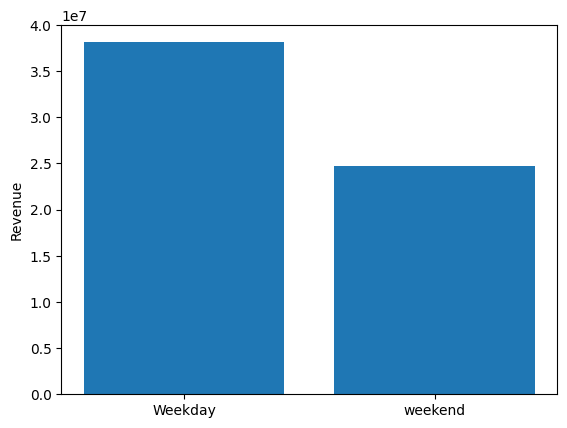

In [ ]:
plt.bar(week['day_type'], week['total_revenue'])
plt.ylabel('Revenue')
plt.show()

Penjualan di akhir pekan (dua hari) menyumbangkan **38.31% dari total pendapatan** menunjukkan intensitas pembelian yang lebih tinggi selama akhir pekan.

### Analisis Waktu

**Produk Apa yang Paling Laku?**

In [ ]:
query = """
SELECT
  ProductName,
  SUM(Quantity) AS total_quantity
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY ProductName
ORDER BY total_quantity DESC
LIMIT 10;
"""
top_qty = pd.read_sql_query(query, conn)
top_qty

,ProductName,total_quantity
0,Paper Craft Little Birdie,80995
1,Medium Ceramic Top Storage Jar,78033
2,Popcorn Holder,56902
3,World War 2 Gliders Asstd Designs,54951
4,Jumbo Bag Red Retrospot,48375
5,Cream Hanging Heart T-Light Holder,37937
6,Pack Of 72 Retrospot Cake Cases,36492
7,Assorted Colour Bird Ornament,36394
8,Rabbit Night Light,30742
9,Mini Paint Set Vintage,26633


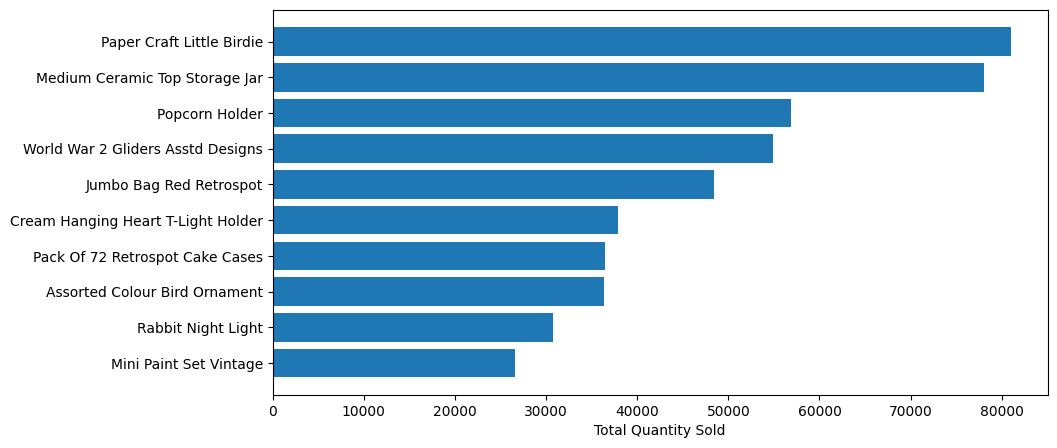

In [ ]:
plt.figure(figsize=(10,5))
plt.barh(top_qty['ProductName'], top_qty['total_quantity'])
plt.gca().invert_yaxis()
plt.xlabel('Total Quantity Sold')
plt.show()

Produk yang paling laku adalah **Paper Craft Little Birdie** yang terjual sebanyak 80.995 dan diikuti oleh **Medium Ceramic Top Storage Jar** yang terjual sebanyak 78.033.

**Produk Apa yang Menghasilkan Revenue Tertinggi?**

In [ ]:
query = """
SELECT
  ProductName,
  SUM(Revenue) AS total_revenue
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY ProductName
ORDER BY total_revenue DESC
LIMIT 10;
"""

top_rev = pd.read_sql_query(query, conn)
top_rev

,ProductName,total_revenue
0,Paper Craft Little Birdie,1002718.10
1,Medium Ceramic Top Storage Jar,881990.18
2,Popcorn Holder,587222.66
3,World War 2 Gliders Asstd Designs,568722.59
4,Cream Hanging Heart T-Light Holder,484354.72
5,Assorted Colour Bird Ornament,420132.72
6,Pack Of 72 Retrospot Cake Cases,391241.08
7,Rabbit Night Light,328529.51
8,Regency Cakestand 3 Tier,306900.94
9,Jumbo Bag Red Retrospot,296584.47


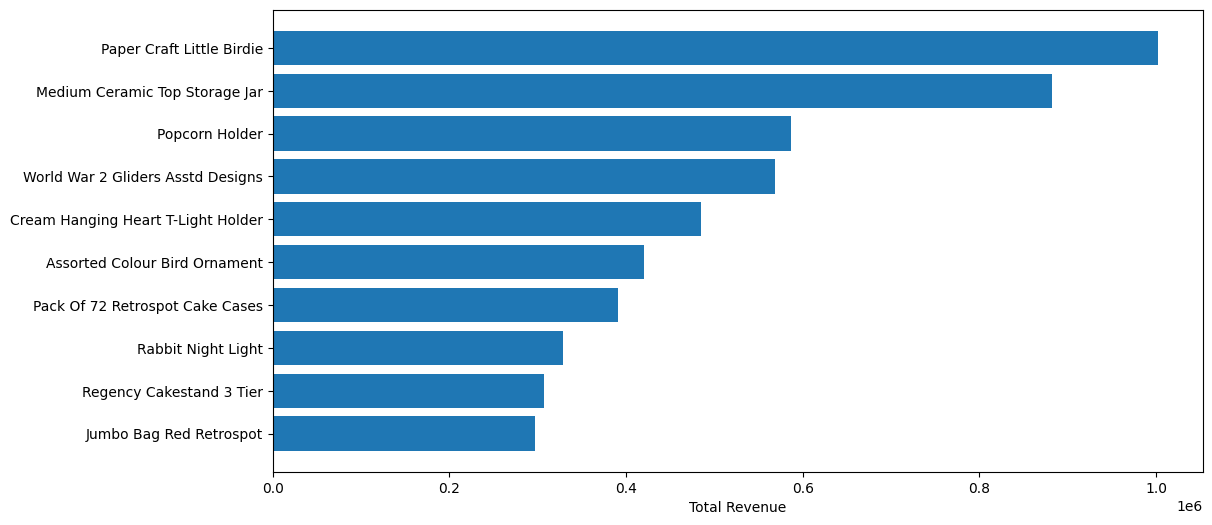

In [ ]:
plt.figure(figsize=(12,6))
plt.barh(top_rev['ProductName'], top_rev['total_revenue'])
plt.gca().invert_yaxis()
plt.xlabel('Total Revenue')
plt.show()

Produk yang memberikan pendapatan terbanyak adalah **Paper Craft Little Birdie** yang menyumbangkan 1.59% dan diikuti oleh **Medium Ceramic Top Storage Jar** yang menyumbangkan 1.3% dari total pendapatan.

Menariknya, produk **Cream Hanging Heart T-Light Holder** terjual lebih sedikit dari Jumbo Bag Red Retrospot, tetapi memiliki pendapatan yang lebih tinggi dari Jumbo Bag Red Retrospot. Begitu pula dengan **Assorted Colour Bird Ornament** dan **Regency Cakestand 3 Tier**. Hal ini menunjukkan strategi penetapan harga 'premium'.

**Apakah Ada Produk yang Banyak Dibatalkan?**

In [ ]:
query = """
SELECT
  ProductName,
  ABS(SUM(Quantity)) AS total_canceled_units
FROM sales
WHERE Quantity < 0
GROUP BY ProductName
ORDER BY total_canceled_units DESC
LIMIT 10;
"""
canceled = pd.read_sql_query(query, conn)
canceled

,ProductName,total_canceled_units
0,Paper Craft Little Birdie,80995
1,Medium Ceramic Top Storage Jar,74494
2,Rotating Silver Angels T-Light Hldr,9367
3,Fairy Cake Flannel Assorted Colour,3150
4,Cream Hanging Heart T-Light Holder,2578
5,Gin And Tonic Diet Metal Sign,2030
6,Herb Marker Basil,1527
7,Feltcraft Doll Molly,1447
8,Tea Time Party Bunting,1424
9,Paper Pocket Traveling Fan,1385


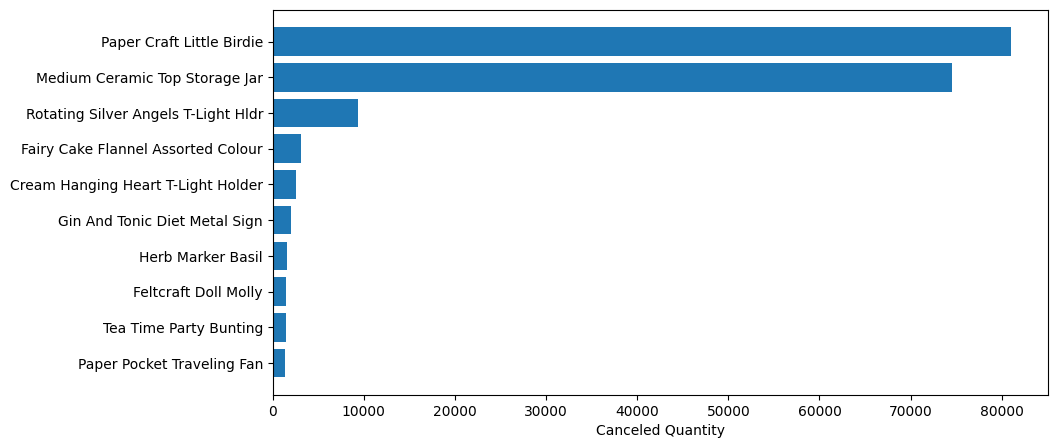

In [ ]:
plt.figure(figsize=(10,5))
plt.barh(canceled['ProductName'], canceled['total_canceled_units'])
plt.gca().invert_yaxis()
plt.xlabel('Canceled Quantity')
plt.show()

Menariknya, produk yang paling banyak dibatalkan adalah produk **Paper Craft Little Birdie** sebanyak 80.995 dan **Medium Ceramic Top Storage Jar** sebanyak 74.494 yang mungkin mengindikasikan masalah kualitas, deskripsi yang tidak akurat, atau masalah logistik.

**Tingkat Pembatalan per Produk**

In [ ]:
query = """
SELECT
  ProductName,
  SUM(CASE WHEN Quantity < 0 THEN ABS(Quantity) ELSE 0 END) * 1.0 /
  SUM(CASE WHEN Quantity > 0 THEN Quantity ELSE 0 END) AS cancellation_rate
FROM sales
GROUP BY ProductName
HAVING SUM(CASE WHEN Quantity > 0 THEN Quantity ELSE 0 END) > 0
ORDER BY cancellation_rate DESC
LIMIT 10;
"""
cancel_rate = pd.read_sql_query(query, conn)
cancel_rate

,ProductName,cancellation_rate
0,Blue Padded Soft Mobile,7.000000
1,Pink Poodle Hanging Decoration,2.400000
2,Pink Cherry Lights,2.000000
3,Wooden Box Advent Calendar,1.600000
4,3 Wick Christmas Briar Candle,1.333333
5,Robin Christmas Card,1.200000
6,Pink Small Glass Cake Stand,1.125000
7,White Beaded Garland String 20light,1.000000
8,Paper Craft Little Birdie,1.000000
9,Hanging Ridge Glass T-Light Holder,1.000000


Meskipun Paper Craft Little Birdie dan Medium Ceramic Top Storage Jar mencatat volume pembatalan tertinggi secara kuantitas, produk **Blue Padded Soft Mobile** justru menempati urutan pertama dalam hal persentase tingkat pembatalan (cancellation rate). Temuan ini menegaskan bahwa volume absolut tidak selalu menjadi indikator utama risiko. Fokus perhatian perlu dialihkan pada Blue Padded Soft Mobile berdasarkan apakah tingkat pembatalannya telah melampaui ambang batas toleransi yang ditetapkan perusahaan.

### Customer Insights

**Siapa 10 Pelanggan yang Paling Banyak Belanja?**

In [ ]:
query = """
SELECT
  CustomerNo,
  SUM(Revenue) as total_spent
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY CustomerNo
ORDER BY total_spent DESC
LIMIT 10;
"""
top_customers = pd.read_sql_query(query, conn)
top_customers

,CustomerNo,total_spent
0,14646.0,2112282.03
1,16446.0,1002741.57
2,14911.0,914204.19
3,12415.0,900545.54
4,18102.0,897137.36
5,17450.0,891069.53
6,12346.0,840113.80
7,14156.0,694202.51
8,13694.0,646116.78
9,17511.0,639006.19


10 Pelanggan dari 4.718 total pelanggan di tabel atas menyumbang **15.19%** pendapatan kepada perusahaan. Hal ini menunjukkan adanya pelanggan yang setia dan bernilai tinggi (VIP).

**Berapa Banyak Pelanggan yang Melakukan Pembelian Lebih Dari 1 Kali?**

In [ ]:
query = """
SELECT
  COUNT(*) AS repeat_customers
FROM (
  SELECT CustomerNo
  FROM sales
  WHERE Quantity > 0
  GROUP BY CustomerNo
  HAVING COUNT(DISTINCT TransactionNo) > 1
);
"""
pd.read_sql_query(query, conn)

,repeat_customers
0,3141


Terdapat **3.141** dari 4.718 total pelanggan yang melakukan transaksi lebih dari 1 kali.

**Berapa Tingkat Pengulangan Pembelian yang Dilakukan oleh Pelanggan?**

In [ ]:
query1 = """
SELECT
  COUNT(*) AS repeat_customers
FROM (
  SELECT
    CustomerNo
  FROM sales
  WHERE Quantity > 0
  GROUP BY CustomerNo
  HAVING COUNT (DISTINCT TransactionNo) > 1
);
"""

query2 = """
SELECT
  COUNT(DISTINCT CustomerNo) as total_customers
FROM sales
WHERE Quantity > 0;
"""

repeat_customers = pd.read_sql_query(query1, conn)
total_customers = pd.read_sql_query(query2, conn)

repeat_rate = repeat_customers['repeat_customers'][0] / total_customers['total_customers'][0]
print(f"{(repeat_rate * 100):.2f}%")

66.57%


Terdapat **66.57% pelanggan** yang melakukan transaksi lebih dari 1 kali. Hal ini menunjukkan potensi peluang bagi perusahaan untuk meningkatkan retensi dengan sistem membership atau strategi lainnya.

**Pembelian Rata-rata Value Setiap Pelanggan**

In [ ]:
query = """
SELECT
  CustomerNo,
  AVG(order_value) AS avg_purchase_value
FROM (
  SELECT
    CustomerNo,
    TransactionNo,
    SUM(Revenue) AS order_value
  FROM sales
  WHERE Quantity > 0 AND Price > 0
  GROUP BY CustomerNo, TransactionNo
)
GROUP BY CustomerNo
ORDER BY avg_purchase_value DESC
LIMIT 10;
"""
avg_purchase = pd.read_sql_query(query, conn)
avg_purchase

,CustomerNo,avg_purchase_value
0,12346.0,840113.800
1,16446.0,501370.785
2,15941.0,184880.850
3,14365.0,184148.760
4,18251.0,84622.080
5,14203.0,78231.140
6,13256.0,77622.600
7,15749.0,76802.800
8,12590.0,49891.400
9,16754.0,45914.400


Terdapat perbedaan kontras antara tabel Average Purchase Value (APV) dan Total Spent. **Pelanggan dengan total pengeluaran tertinggi namun memiliki APV rendah** menunjukkan mereka sangat sering bertransaksi meskipun dengan nominal kecil. Sebaliknya, **pelanggan dengan APV tinggi namun total pengeluaran lebih rendah** menunjukkan efisiensi transaksi yang tinggi; mereka jarang bertransaksi, tetapi memiliki daya beli besar dalam satu kali kunjungan.

Hal ini menjadi dilema strategis bagi perusahaan: apakah akan mengejar volume transaksi (loyalitas frekuensi) atau memaksimalkan efisiensi operasional (menaikkan APV)?

**Customer Retention**

In [ ]:
query = """
SELECT
  COUNT(*) AS retained_customers
FROM (
  SELECT
    CustomerNo
  FROM sales
  WHERE Quantity > 0
  GROUP BY CustomerNo
  HAVING COUNT(DISTINCT strftime('%Y-%m', Date)) > 1
);
"""
retained_customers = pd.read_sql_query(query, conn)
retained_customers

,retained_customers
0,3016


Terdapat **63.92% pelanggan** yang melakukan pembelian selama beberapa bulan. Hal ini menunjukkan adanya potensi untuk meningkatkan strategi yang melibatkan pasca-pembelian pelanggan.

### Regional / Negara

**Negara mana yang Paling Banyak Transaksi?**

In [ ]:
query = """
SELECT
  Country,
  COUNT(DISTINCT TransactionNo) AS total_transactions
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY Country
ORDER BY total_transactions DESC
LIMIT 10;
"""
transactions_country = pd.read_sql_query(query, conn)
transactions_country

,Country,total_transactions
0,United Kingdom,17907
1,Germany,453
2,France,404
3,EIRE,277
4,Belgium,97
5,Netherlands,94
6,Spain,78
7,Australia,62
8,Switzerland,55
9,Portugal,52


**Inggris** mendominasi volume transaksi, menunjukkan bahwa negara ini merupakan pasar paling aktif dalam hal frekuensi pembelian.

**Revenue per Negara?**

In [ ]:
query = """
SELECT
  Country,
  SUM(Revenue) as total_revenue
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY Country
ORDER BY total_revenue DESC
LIMIT 10;
"""

country_revenue = pd.read_sql_query(query, conn)
country_revenue

,Country,total_revenue
0,United Kingdom,5.234680e+07
1,Netherlands,2.151554e+06
2,EIRE,1.711819e+06
3,Germany,1.369840e+06
4,France,1.329903e+06
5,Australia,9.954140e+05
6,Sweden,4.018799e+05
7,Switzerland,3.616920e+05
8,Japan,2.931554e+05
9,Spain,2.808438e+05


Beberapa negara menghasilkan pendapatan tinggi meskipun memiliki jumlah transaksi yang lebih sedikit. Hal ini menunjukkan nilai pesanan rata-rata yang lebih tinggi pada beberapa negara lain, selain Inggris.

**Jumlah Pelanggan per Negara**

In [ ]:
query = """
SELECT
  Country,
  COUNT(DISTINCT CustomerNo) as total_customers
FROM sales
WHERE Quantity > 0
GROUP BY Country
ORDER BY total_customers DESC;
"""

customers_each_country = pd.read_sql_query(query, conn)
customers_each_country

,Country,total_customers
0,United Kingdom,4305
1,Germany,91
2,France,87
3,Spain,23
4,Belgium,22
5,Switzerland,21
6,Portugal,18
7,EIRE,13
8,Italy,12
9,Finland,12


Tabel jumlah pelanggan menunjukkan bahwa jumlah pelanggan tidak selalu mempengaruhi jumlah pendapatan maupun jumlah transaksi yang dilakukan dari negara tersebut. Misalnya: **Negara Belanda** memiliki jumlah pelanggan yang sangat kecil, tetapi mencapai posisi kedua sebagai negara dengan jumlah pendapatan tertinggi dan mencapai posisi 10 besar sebagai negara dengan jumlah transaksi terbanyak.  

**Rasio Revenue Negara vs Jumlah Pelanggan?**

In [ ]:
query = """
SELECT
  Country,
  SUM(Revenue) as total_revenue,
  COUNT(DISTINCT CustomerNo) as total_customers,
  ROUND(SUM(Revenue) * 1.0 / COUNT(DISTINCT CustomerNo), 2) AS revenue_per_customer
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY Country
HAVING total_customers >= 10
ORDER BY revenue_per_customer DESC;
"""

revenue_per_customer = pd.read_sql_query(query, conn)
revenue_per_customer

,Country,total_revenue,total_customers,revenue_per_customer
0,EIRE,1.711819e+06,13,131678.41
1,Switzerland,3.616920e+05,21,17223.43
2,France,1.329903e+06,87,15286.25
3,Germany,1.369840e+06,91,15053.18
4,Belgium,2.721319e+05,22,12369.63
5,Spain,2.808438e+05,23,12210.60
6,United Kingdom,5.234680e+07,4305,12159.53
7,Finland,1.209722e+05,12,10081.01
8,Portugal,1.759593e+05,18,9775.52
9,Italy,7.853624e+04,12,6544.69


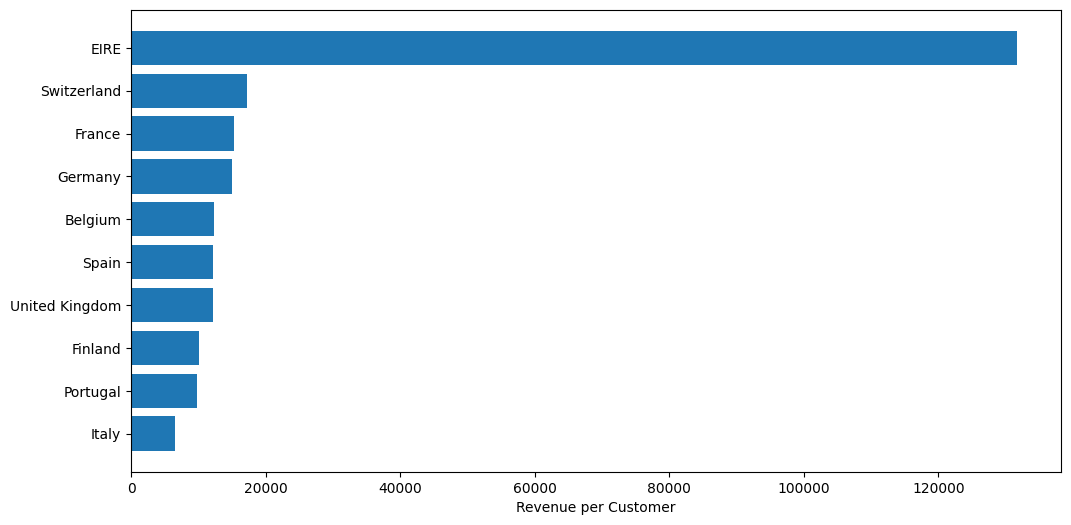

In [ ]:
plt.figure(figsize=(12, 6))
plt.barh(revenue_per_customer['Country'],
         revenue_per_customer['revenue_per_customer'])
plt.xlabel('Revenue per Customer')
plt.gca().invert_yaxis()
plt.show()

Selain negara Belanda, negara Ireland juga menjadi sorotan. **Negara Irlandia** memiliki pelanggan yang cukup rendah, tetapi menunjukkan pendapatan per pelanggan yang jauh lebih tinggi dari negara lain. Hal ini mengindikasikan perilaku pembelian 'premium'.

### Unit Price & Quantity

**Apakah Ada Hubungan antara Harga & Jumlah Pembelian?**

In [ ]:
query = """
SELECT
  ProductNo,
  ProductName,
  AVG(Price) AS avg_price,
  SUM(Quantity) AS total_quantity,
  SUM(Revenue) AS total_revenue
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY ProductNo, ProductName;
"""
product_metrics = pd.read_sql_query(query, conn)
product_metrics.head()

,ProductNo,ProductName,avg_price,total_quantity,total_revenue
0,10002,Inflatable Political Globe,11.362535,860,9592.81
1,10080,Groovy Cactus Inflatable,10.671364,303,3227.89
2,10120,Doggy Rubber,10.061379,192,1967.30
3,10123C,Hearts Wrapping Tape,10.920000,5,54.60
4,10124A,Spots On Red Bookcover Tape,10.680000,16,170.88


In [ ]:
product_metrics[['avg_price', 'total_quantity']].corr()

,avg_price,total_quantity
avg_price,1.000000,-0.054771
total_quantity,-0.054771,1.000000


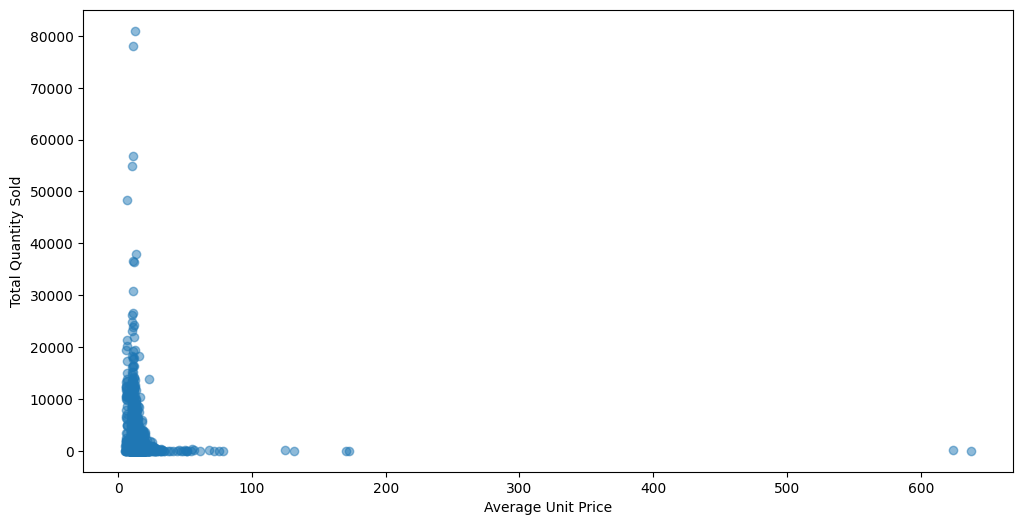

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(product_metrics['avg_price'],
            product_metrics['total_quantity'],
            alpha=0.5)
plt.xlabel('Average Unit Price')
plt.ylabel('Total Quantity Sold')
plt.show()

Grafik di atas menunjukkan bahwa hampir **tidak ada hubungan** antara harga produk dengan jumlah pembelian.

**Apakah Produk yang Memiliki Quantity Tinggi Juga selalu Memiliki Revenue Tinggi?**

In [ ]:
query = """
SELECT
  ProductNo,
  ProductName,
  SUM(Quantity) AS total_quantity,
  SUM(Revenue) AS total_revenue
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY ProductNo, ProductName
ORDER BY total_revenue DESC;
"""
product_metrics = pd.read_sql_query(query, conn)
product_metrics

,ProductNo,ProductName,total_quantity,total_revenue
0,23843,Paper Craft Little Birdie,80995,1002718.10
1,23166,Medium Ceramic Top Storage Jar,78033,881990.18
2,22197,Popcorn Holder,56902,587222.66
3,84077,World War 2 Gliders Asstd Designs,54951,568722.59
4,85123A,Cream Hanging Heart T-Light Holder,37937,484354.72
...,...,...,...,...
3748,84977,Wire Flower T-Light Holder,1,11.53
3749,90084,Pink Crystal Guitar Phone Charm,1,11.12
3750,84227,Hen House W Chick In Nest,1,10.68
3751,23609,Set 10 Cards Snowy Robin 17099,1,6.19


In [ ]:
product_metrics[['total_quantity', 'total_revenue']].corr()

,total_quantity,total_revenue
total_quantity,1.000000,0.978868
total_revenue,0.978868,1.000000


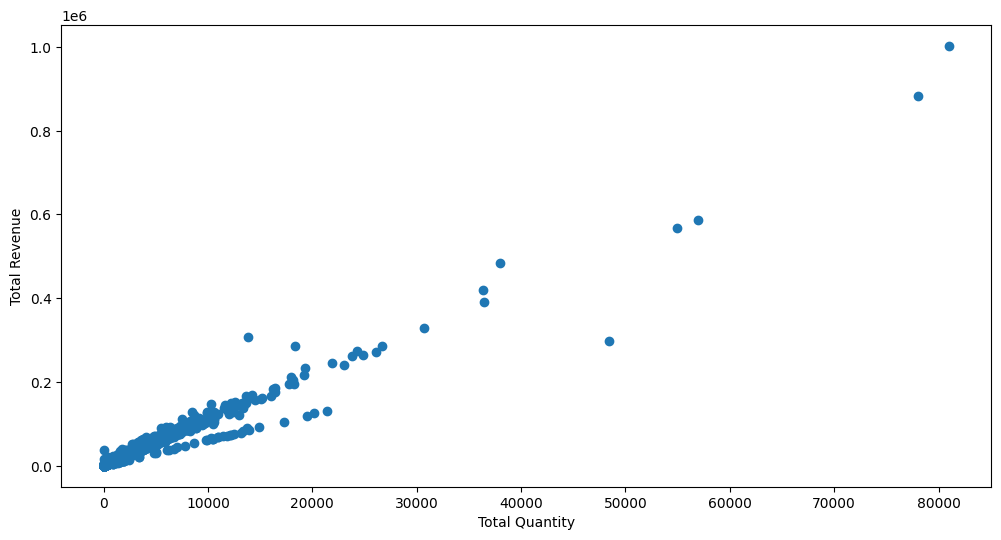

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(product_metrics['total_quantity'],
            product_metrics['total_revenue'])
plt.xlabel('Total Quantity')
plt.ylabel('Total Revenue')
plt.show()

Grafik menunjukkan bahwa produk yang memiliki quantity yang tinggi **hampir selalu** memiliki pendapatan (revenue) yang tinggi.

### Custom Segmentation

**Segmentasi Pelanggan berdasarkan RFM**

In [ ]:
query = """
SELECT
  CustomerNo,
  MAX(Date) AS last_purchase_date,
  COUNT(DISTINCT TransactionNo) AS frequency,
  SUM(Revenue) AS monetary
FROM sales
WHERE Quantity > 0 AND Price > 0
GROUP BY CustomerNo;
"""
rfm = pd.read_sql_query(query, conn)
rfm

,CustomerNo,last_purchase_date,frequency,monetary
0,12004.0,2019-04-26 00:00:00,1,1509.60
1,12006.0,2019-05-05 00:00:00,1,24.76
2,12008.0,2019-03-08 00:00:00,1,5689.57
3,12013.0,2018-12-15 00:00:00,1,69.96
4,12024.0,2019-06-16 00:00:00,1,149.52
...,...,...,...,...
4713,18280.0,2019-03-07 00:00:00,1,623.26
4714,18281.0,2019-06-12 00:00:00,1,576.58
4715,18282.0,2019-12-02 00:00:00,2,1044.86
4716,18283.0,2019-12-06 00:00:00,16,11773.90


In [ ]:
rfm['last_purchase_date'] = pd.to_datetime(rfm['last_purchase_date'])
snapshot_date = rfm['last_purchase_date'].max()

rfm['recency'] = (snapshot_date - rfm['last_purchase_date']).dt.days
rfm.head()

,CustomerNo,last_purchase_date,frequency,monetary,recency
0,12004.0,2019-04-26,1,1509.60,227
1,12006.0,2019-05-05,1,24.76,218
2,12008.0,2019-03-08,1,5689.57,276
3,12013.0,2018-12-15,1,69.96,359
4,12024.0,2019-06-16,1,149.52,176


In [ ]:
rfm['R_score'] = pd.qcut(rfm['recency'], 5, labels=False, duplicates='drop')
rfm['R_score'] = 4 - rfm['R_score']
rfm['F_score'] = pd.qcut(rfm['frequency'], 5, labels=False, duplicates='drop')
rfm['M_score'] = pd.qcut(rfm['monetary'], 5, labels=False, duplicates='drop')

In [ ]:
def segment(row):
    if (row['R_score'] >= 3) and (row['F_score'] >= 3) and (row['M_score'] >= 3):
        return 'Champions'
    elif row['R_score'] >= 3 and row['F_score'] >= 2:
        return 'Loyal Customers'
    elif row['F_score'] >= 3:
        return 'Frequent Buyers'
    else:
        return 'At Risk'

rfm['segment'] = rfm.apply(segment, axis=1)
rfm['segment'].value_counts()

,count
segment,
At Risk,3411
Champions,703
Loyal Customers,414
Frequent Buyers,190


Keempat segment di atas menunjukkan pengelompokkan pelanggan berdasarkan frekuensi dan nilai belanja mereka terhadap produk perusahaan:

1. **At Risk**: Pelanggan yang sudah lama tidak belanja, frekuensi rendah, dan nilai belanja kecil
2. **Champions**: Pelanggan yang baru belanja akhir-akhir ini, sering belanja, dan nilai belanja yang tinggi
3. **Loyal Customers**: Pelanggan yang masih aktif dan relatif sering belanja, tetapi tidak setinggi Champions
4. **Frequent Buyers**: Pelanggan yang sering beli, tetapi nilai belanja per transaksi rendah.

Sebagian besar pelanggan termasuk dalam segmen 'At Risk', sementara sebagian kecil pelanggan 'Champions' kemungkinan memberikan kontribusi yang signifikan terhadap total pendapatan. Hal ini menyoroti pentingnya mempertahankan loyalitas pelanggan Champions dan menaikkan pelanggan dari segmen Loyal Customers, Frequent Buyers, dan At Risk ke Champions.